# Определение возраста покупателей

<div style="font-family: Arial; padding: 10px; border: 1px solid black; margin: 10px;">
    <h2>Проект "Определение возраста покупателей"</h2>
    <p>В этой работе я планирую разработать модель, которая будет определять возраст покупателей в магазине "Хлеб-Соль". Передо мной стоят две задачи:</p>
    <ol>
        <li>Научиться определять возраст для рекомендации акций.</li>
        <li>Определять возраст для контроля продажи алкоголя.</li>
    </ol>
    <p>Данная задача будет решаться с использованием нейронных сетей. В своей работе я буду использовать сеть ResNet50, которая уже предобучена на большом наборе данных.</p>
    <p>Основной метрикой для оценки качества модели будет MAE, так как она подходит для задачи регрессии и легко интерпретируема. Функцией потерь будет MSE, поскольку она более чувствительна к выбросам и легко дифференцируема, что упрощает оптимизацию.</p>
    <h3>План работы</h3>
    <ol>
        <li>Провести обзор данных.</li>
        <li>Посмотреть распределение.</li>
        <li>Построить и обучить модель на внутренних серверах ЯП. Поэтому весь код будет в строке с текстом.</li>
    </ol>
</div>





## Исследовательский анализ данных

In [2]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [3]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [4]:
labels.head(3)

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80


In [5]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


<div style="font-family: Arial; padding: 10px; border: 1px solid black; margin: 10px;">
    <h3>Выводы из первичного анализа данных:</h3>
<p>В нашем наборе данных 7.5 тысяч элементов, они хранятся в датасете, который содержит два столбца. В первом столбце отражено название файла, а во втором - возраст изображенного на картинке человека. Число в 7.5 тысяч является достаточно большим, его хватит для обучения модели, но мы применим предобученную сеть для повышения качества предсказания.</p>
</div>

In [6]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


<Figure size 720x288 with 0 Axes>

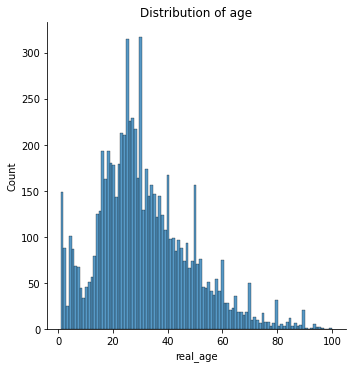

In [10]:
plt.figure(figsize=(10,4))
sns.displot(labels.real_age, kde=False, bins=100)
plt.title("Distribution of age")
plt.show()

<div style="font-family: Arial; padding: 10px; border: 1px solid black; margin: 10px;">
    <h3>Выводы из анализа распределения данных:</h3>
    <ul>
        <li>Данные включают в себя широкий спектр возрастов от 1 года до 100 лет, что говорит о том, что модель, обученная на этих данных, будет способна предсказывать возраст для широкого спектра возрастных групп.</li>
        <li>Средний возраст и медиана близки друг к другу и составляют около 30 лет. Это указывает на то, что большая часть выборки сосредоточена вокруг этого возраста.</li>
        <li>Однако стандартное отклонение велико (17 лет), что говорит о значительном разнообразии возрастов в данных. Это может создавать дополнительные сложности при обучении модели, так как требуется учесть большое количество возрастных групп.</li>
        <li>Большинство людей в выборке (между 25-м и 75-м перцентилями) находятся в возрастном диапазоне от 20 до 41 года. Это может означать, что модель будет лучше работать для предсказания возраста в этом диапазоне, поскольку она получит больше данных для обучения из этого возрастного диапазона.</li>
        <li> Данные содержать выбросы, особенно для очень молодых и очень старых возрастов, что может затруднить обучение и предсказание.</li>
    </ul>
</div>

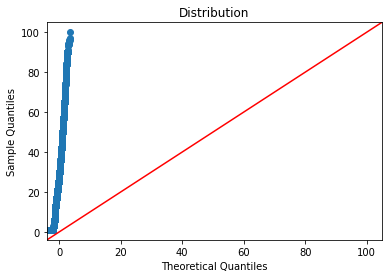

In [8]:
fig = sm.qqplot(labels.real_age, line='45')
plt.title("Distribution")
plt.show()

<div style="font-family: Arial; padding: 10px; border: 1px solid black; margin: 10px;">
    <h3>Выводы из анализа распределения данных:</h3>
<p>На нашем графике точки образуют вертикальную линию, которая сильно отклонена от линии под 45 градусов. Это указывает на то, что распределение данных существенно отличается от предполагаемого теоретического распределения. Это может привести к следующим проблемам:</p>
<ul>
<li>Если данные сильно смещены или несбалансированы, это может замедлить сходимость, вызвать переобучение или недообучение.</li>
<li>Выбросы могут вызвать искажения в обучении.</li>
</ul>
<p>Но мы планируем использовать уже предобученную модель, поэтому такое распределение нас устроит, иначе мы можем исказить процесс обучения.</p>
</div>

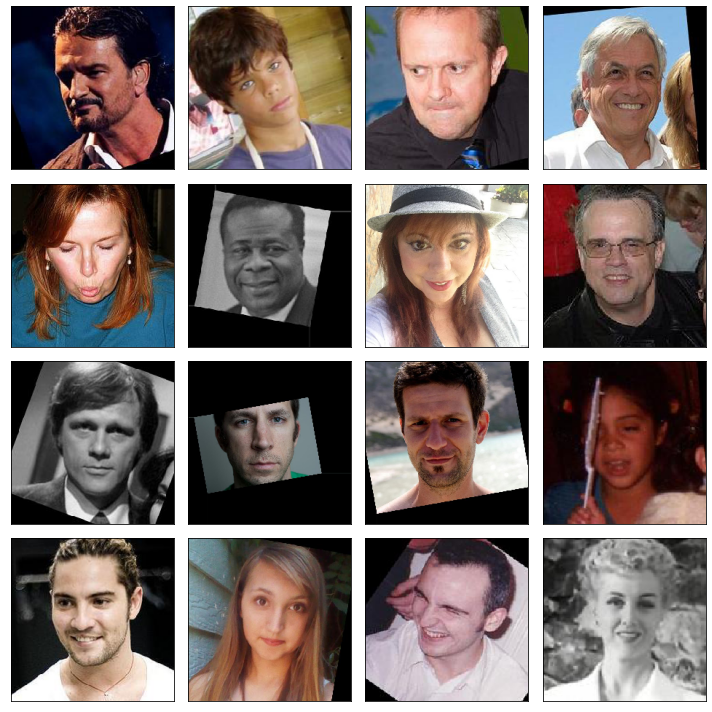

In [11]:
features, target = next(train_gen_flow)

fig = plt.figure(figsize=(10,10))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

<div style="font-family: Arial; padding: 10px; border: 1px solid black; margin: 10px;">
    <h3>Выводы из визуального анализа данных:</h3>
    <p>После визуального анализа наших данных можно сделать следующие заметки:</p>
    <ul>
        <li><strong>Неоднородность освещения</strong>: Несмотря на то, что это может представлять некоторую сложность, модель может также научиться выявлять и адаптироваться к различным условиям освещения. Это может сделать модель более устойчивой и эффективной при работе с реальными изображениями, которые могут быть сняты в различных условиях освещения.</li>
        <li><strong>Вариация позы и ориентации</strong>: Обучение на таком разнообразии может помочь модели стать более гибкой в распознавании возраста людей в разных позах и ориентациях. Это может быть особенно полезно в реальных условиях, где лица не всегда будут идеально центрированы и в профиле.</li>
        <li><strong>Фактор бороды</strong>: Несмотря на то, что борода может представлять проблему, она также может дать модели дополнительную информацию для обучения. Например, дети не имеют бороды, поэтому наличие бороды может помочь модели определить, что на фото взрослый, а не ребенок.</li>
        <li><strong>Черные области вокруг изображений</strong>: Хотя эти области в основном не содержат полезной информации, они могут действовать как фоновый шум, который может помочь модели обучиться игнорировать нерелевантную информацию и сосредоточиться на наиболее важных признаках.</li>
    </ul>
</div>


## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python
def load_train(path):

    df = pd.read_csv('/datasets/faces/labels.csv')

    train_datagen = ImageDataGenerator(
        rescale=1. / 255,
        validation_split=0.2)

    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=df,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow

def load_test(path):

    df = pd.read_csv('/datasets/faces/labels.csv')

    valid_datagen = ImageDataGenerator(
        rescale=1. / 255, 
        validation_split=0.2)

    validation_gen_flow = valid_datagen.flow_from_dataframe(
        dataframe=df,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return validation_gen_flow

def create_model(input_shape):

    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet',
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Flatten())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=5,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

```

```

Train for 190 steps, validate for 48 steps
Epoch 1/5
2023-05-15 12:52:43.035940: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-05-15 12:52:44.328789: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
190/190 - 87s - loss: 261.9841 - mae: 11.4861 - val_loss: 584.8924 - val_mae: 19.0432
Epoch 2/5
190/190 - 53s - loss: 64.1291 - mae: 6.0369 - val_loss: 508.8601 - val_mae: 17.3532
Epoch 3/5
190/190 - 51s - loss: 31.8993 - mae: 4.3517 - val_loss: 261.5426 - val_mae: 11.8323
Epoch 4/5
190/190 - 42s - loss: 20.0928 - mae: 3.4667 - val_loss: 100.3163 - val_mae: 7.7738
Epoch 5/5
190/190 - 51s - loss: 15.2542 - mae: 3.0469 - val_loss: 74.1050 - val_mae: 6.5259
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
48/48 - 8s - loss: 74.1050 - mae: 6.5259
Test MAE: 6.5259
```

<div style="font-family: Arial; padding: 10px; border: 1px solid black; margin: 10px;">
    <strong>Подготовка данных:</strong>
    <p>Данные были загружены с помощью функций <code>load_train</code> и <code>load_test</code>, которые используют <code>ImageDataGenerator</code>. Этот генератор автоматически масштабирует значения пикселей изображений, делая их подходящими для использования в модели.</p>
    <strong>Архитектура модели:</strong>
    <p>Использовалась модель ResNet50 в качестве основы (бэкбона). ResNet50 - это модель, разработанная компанией Microsoft и имеющая 50 слоев. Она была предварительно обучена на наборе данных ImageNet, что позволяет использовать уже выученные признаки для нашей задачи. К этой модели был добавлен новый слой <code>GlobalAveragePooling2D</code> для уменьшения размерности данных, слой <code>Flatten</code> для преобразования двумерных данных в одномерные и выходной слой <code>Dense</code> с одним нейроном и активационной функцией 'relu'.</p>
    <strong>Параметры обучения:</strong>
    <p>Модель обучалась с использованием оптимизатора Adam с learning rate 0.0001. Потери оценивались с помощью среднеквадратичной ошибки (MSE), а метрикой, используемой для оценки модели, была средняя абсолютная ошибка (MAE). Размер батча был установлен равным 32, а количество эпох обучения 5.</p>
</div>

## Анализ обученной модели

<div style="font-family: Arial; padding: 10px; border: 1px solid black; margin: 10px;">
    <h3>Вывод:</h3>
    <p>В ходе работы над проектом была разработана модель на основе нейронной сети ResNet50 для определения возраста покупателей в магазине "Хлеб-Соль". Задача стояла двоякая: определять возраст для персонализации акций и для контроля продажи алкоголя. В результате обучения модели на представленных данных мы получили значение метрики MAE равное 6.5259.</p>
    <p>Это означает, что в среднем наша модель ошибается на 6.5 лет при определении возраста. В контексте наших задач, это означает, что модель может быть полезной для определения возраста в целях персонализации акций, так как точность в несколько лет обычно не является критической в этом случае. Однако, в контексте контроля продажи алкоголя, такая ошибка может быть существенной, особенно для покупателей, возраст которых близок к законному возрасту покупки алкоголя. Возможно, потребуется дальнейшая настройка модели или использование дополнительных данных для обучения, чтобы улучшить ее производительность для этой задачи.</p>
    <p>Несмотря на то, что модель показала неплохой результат, всегда есть возможность для улучшения. Возможные направления для дальнейшей работы включают исследование и применение других архитектур нейронных сетей, использование ансамблей моделей и/или дополнительного тюнинга гиперпараметров.</p>
</div>